Recreating mixup augmentation tutorial in tensorflow

In [30]:
import tensorflow as tf
from tensorflow.keras import Model, Sequential
from tensorflow.keras.layers import Layer, Conv2D, BatchNormalization, MaxPooling2D
from tensorflow.keras.layers import Dropout, Dense, Flatten, Input
from tensorflow.keras.losses import Loss
import numpy as np
import matplotlib.pyplot as plt
from sklearn.mixture import GaussianMixture
import random
import time

Loading MNIST dataset and limiting size to 2000 for fast execution

In [31]:
data_size = 2000
lr = 0.001
batch_size = 128
val_frac = 0.2
num_epochs = 50
random.seed(123)
np.random.seed(123)
tf.random.set_seed(123)

In [32]:
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.mnist.load_data()

x_train = x_train[:data_size].astype(np.float32)/255.0
y_train = y_train[:data_size]
x_test = x_test.astype(np.float32)/255.0
x_train = x_train.reshape((-1, 28, 28, 1))
x_test = x_test.reshape((-1, 28, 28, 1))

Preparing datasets and normalizing data

In [33]:
def get_mean_std(images):
    mean = ()
    std = ()
    for i in range(images.shape[-1]):
        mean += (np.mean(images[:, :, :, i]),)
        std += (np.std(images[:, :, :, i]),)
    return mean, std

def normalize(images, mean, std):
    for i in range(images.shape[-1]):
        images[:, :, :, i] = (images[:, :, :, i] - mean[i])/std[i]
    return images

mean, std = get_mean_std(x_train)
x_train = normalize(x_train, mean, std)
x_test = normalize(x_test, mean, std)

In [34]:
def convert_to_one_hot(image, label):
    label = tf.one_hot(label, 10)
    return image, tf.cast(label, tf.float32)

In [35]:
def train_val_split(x_train, y_train, val_frac=0.2):
    perm_idx = np.random.permutation(x_train.shape[0])
    val_idx = perm_idx[:int(val_frac*x_train.shape[0])]
    train_idx = perm_idx[int(val_frac*x_train.shape[0]):]
    x_val, y_val = x_train[val_idx], y_train[val_idx]
    x_train, y_train = x_train[train_idx], y_train[train_idx]
    return (x_train, y_train), (x_val, y_val)

In [96]:
# (x_train_base, y_train_base), (x_val, y_val) = train_val_split(x_train, y_train, 0.2)
x_train_base, y_train_base = x_train, y_train
train_ds = (tf.data.Dataset.from_tensor_slices((x_train_base, y_train_base))
                            .map(convert_to_one_hot, num_parallel_calls=tf.data.AUTOTUNE)
                            .batch(batch_size))
# val_ds = (tf.data.Dataset.from_tensor_slices((x_val, y_val))
#                             .map(convert_to_one_hot, num_parallel_calls=tf.data.AUTOTUNE)
#                             .batch(batch_size))
test_ds = (tf.data.Dataset.from_tensor_slices((x_test, y_test))
                            .map(convert_to_one_hot, num_parallel_calls=tf.data.AUTOTUNE)
                            .batch(batch_size))

Plotting some images

In [37]:
def plot_images(ds):
    plt.figure(figsize=(12, 12))
    for images, targets in ds.take(1):
        for i in range(9):
            plt.subplot(3, 3, i+1)
            plt.imshow(images[i], cmap='gray')
            plt.title(np.argmax(targets[i].numpy()))


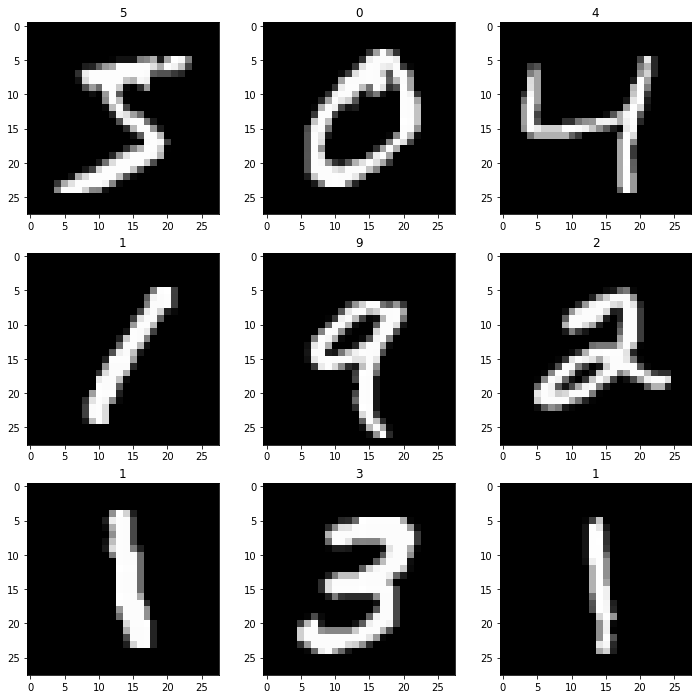

In [38]:
plot_images(train_ds)

Defining model and compile parameters

In [39]:
class base_model(Model):
    def __init__(self, num_classes=10):
        super(base_model, self).__init__()        
        self.conv1 = Conv2D(10, kernel_size = 5, padding='same')
        self.pool1 = MaxPooling2D(pool_size = 2)
        self.conv2 = Conv2D(20, kernel_size = 3, padding = 'same')     
        self.drop1 = Dropout(0.5)
        self.pool2 = MaxPooling2D(pool_size = 2)
        self.flatten = Flatten()
        self.dense1 = Dense(30, activation = 'relu')
        self.drop2 = Dropout(0.5)
        self.dense2 = Dense(num_classes, activation = 'softmax')

    def call(self, input_tensor, training=False):
        x = self.conv1(input_tensor)
        x = tf.nn.relu(self.pool1(x))
        x = self.drop1(self.conv2(x))
        x = tf.nn.relu(self.pool2(x))
        x = self.flatten(x)
        x = self.dense1(x)
        x = self.drop2(x)
        return self.dense2(x)    
        

Building training, evaluation and testing loops

In [115]:
def fit_gmm(losses):    
    losses = losses.numpy()
    losses = (losses-losses.min())/(losses.max()-losses.min())
    input_loss = np.reshape(losses, [-1, 1])

    gmm = GaussianMixture(n_components=2, max_iter=50, tol=1e-2, reg_covar=5e-4)
    gmm.fit(input_loss)
    prob = gmm.predict_proba(input_loss)
    prob = prob[:, gmm.means_.argmin()]
    return prob

class train_step_func():    
    def __init__(self, loss_f):
        self.loss_fn = loss_f
    
    @tf.function
    def __call__(self, x_batch, y_batch):
        with tf.GradientTape() as tape:
            y_pred = model(x_batch, training=True)   
            loss = self.loss_fn(y_batch, y_pred)     
        gradients = tape.gradient(loss, model.trainable_weights)
        optimizer.apply_gradients(zip(gradients, model.trainable_weights))        
        y_batch_single = tf.math.argmax(y_batch, axis = 1)
        y_pred_single = tf.math.argmax(y_pred, axis = 1)
        correct = tf.math.reduce_sum(tf.where(y_pred_single == y_batch_single, 1.0, 0.0))
        return loss, correct

class val_step_func():
    def __init__(self, loss_f):
        self.loss_fn = loss_f
   
    @tf.function
    def __call__(self, x_batch, y_batch):
        y_pred = model(x_batch)
        loss = self.loss_fn(y_batch, y_pred)
        y_pred_single = tf.math.argmax(y_pred, axis=1)
        y_batch_single = tf.math.argmax(y_batch, axis = 1)  
        correct = tf.math.reduce_sum(tf.where(y_pred_single == y_batch_single, 1.0, 0.0)) 
        return loss, correct

@tf.function
def test_step(x_batch, y_batch):    
    y_pred_single = tf.math.argmax(model(x_batch, training=False), axis=1)
    y_batch_single = tf.math.argmax(y_batch, axis = 1)
    correct = tf.math.reduce_sum(tf.where(y_pred_single == y_batch_single, 1.0, 0.0))
    return correct

def train_test_model(
                        train_ds,
                        val_ds,
                        test_ds,
                        loss_func,
                        loss_func_2,
                        num_epochs=1
                    ):
    logs = {'train_loss':[], 'train_acc':[], 'val_loss':[], 'val_acc':[]}
    num_classes = 10
    len_train_ds = len(list(train_ds.unbatch()))
    len_val_ds = len(list(val_ds.unbatch()))
    len_test_ds = len(list(test_ds.unbatch()))

    for epoch in range(num_epochs):          
        # training
        train_loss = tf.zeros(1)
        train_correct = tf.zeros(1)
        train_step = train_step_func(loss_func) 
        for batch_id, (x_batch, y_batch) in enumerate(train_ds):  
            loss, correct = train_step(x_batch, y_batch)
            train_loss += loss*len(y_batch)
            train_correct += correct
        train_loss /= len_train_ds
        train_acc = train_correct/len_train_ds

        # validation
        losses = tf.Variable(tf.zeros(len_val_ds))
        val_correct = tf.zeros(1)
        val_loss = tf.zeros(1)
        val_step = val_step_func(loss_func_2)
        for idx, (x_batch, y_batch) in enumerate(val_ds):
            loss, correct = val_step(x_batch, y_batch)
            val_loss += tf.math.reduce_sum(loss)
            val_correct += correct
            for b in tf.range(x_batch.shape[0]):
                i = batch_size*idx+b
                losses[i].assign(tf.cast(loss[b], tf.float32))
        val_loss /= float(len_val_ds)
        val_acc = val_correct/len_val_ds   

        # fit loss to Gaussian mixture model
        prob = fit_gmm(losses)        

        logs['train_loss'].append(train_loss[0].numpy())
        logs['train_acc'].append(train_acc[0].numpy())
        logs['val_loss'].append(val_loss[0].numpy())
        logs['val_acc'].append(val_acc[0].numpy())

        print(f'Epoch [{epoch+1}/{num_epochs}],\ttrain loss: {train_loss[0].numpy():.4f},\ttrain acc: {train_acc[0].numpy()*100:.2f} %,\tvalidation loss: {val_loss[0].numpy():.4f},\tvalidation accuracy: {val_acc[0].numpy()*100:.2f} %')

    # testing 
    test_correct = tf.zeros(1)
    for x_batch, y_batch in test_ds:
        correct = test_step(x_batch, y_batch)
        test_correct += correct
    test_acc = test_correct/len_test_ds
    print(f"Test accuracy : {test_acc[0].numpy()*100:.2f} %")
    return logs
    

Setting model optimizer, loss and accuracy metric, compiling and training model

In [41]:
tf.keras.backend.clear_session()
start_time = time.time()
tf.random.set_seed(123)
model = base_model(10)
loss_func = tf.keras.losses.CategoricalCrossentropy()
loss_func_2 = tf.keras.losses.CategoricalCrossentropy(reduction=tf.losses.Reduction.NONE)
optimizer = tf.keras.optimizers.Adam(lr)
logs_baseline = train_test_model(
                                train_ds, 
                                test_ds, 
                                test_ds, 
                                loss_func, 
                                loss_func_2,  
                                num_epochs)
print(f"Training time : {(time.time() - start_time)/60:.2f} min.")

Epoch [1/50],	train loss: 2.2122,	train acc: 18.80 %,	validation loss: 1.9816,	validation accuracy: 53.79 %
Epoch [2/50],	train loss: 1.7497,	train acc: 38.80 %,	validation loss: 1.5632,	validation accuracy: 65.53 %
Epoch [3/50],	train loss: 1.3842,	train acc: 51.45 %,	validation loss: 1.2186,	validation accuracy: 74.35 %
Epoch [4/50],	train loss: 1.1231,	train acc: 60.45 %,	validation loss: 0.9835,	validation accuracy: 80.49 %
Epoch [5/50],	train loss: 0.9421,	train acc: 67.55 %,	validation loss: 0.8160,	validation accuracy: 83.11 %
Epoch [6/50],	train loss: 0.8153,	train acc: 71.80 %,	validation loss: 0.7048,	validation accuracy: 85.06 %
Epoch [7/50],	train loss: 0.7076,	train acc: 75.10 %,	validation loss: 0.6149,	validation accuracy: 86.32 %
Epoch [8/50],	train loss: 0.6222,	train acc: 78.40 %,	validation loss: 0.5462,	validation accuracy: 87.12 %
Epoch [9/50],	train loss: 0.5579,	train acc: 80.35 %,	validation loss: 0.4933,	validation accuracy: 89.12 %
Epoch [10/50],	train loss: 0

Text(0, 0.5, 'Loss')

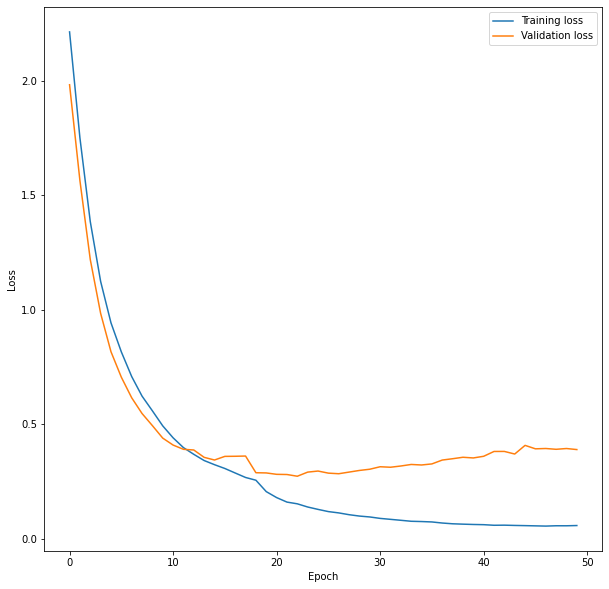

In [42]:
plt.figure(figsize=(10, 10))
plt.plot(range(num_epochs), logs_baseline['train_loss'], label = 'Training loss')
plt.plot(range(num_epochs), logs_baseline['val_loss'], label = 'Validation loss')
plt.legend()
plt.xlabel('Epoch')
plt.ylabel('Loss')

Text(0, 0.5, 'Accuracy')

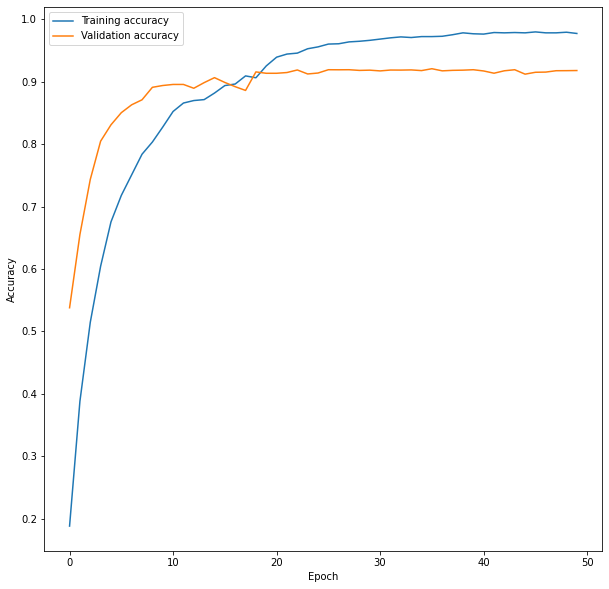

In [43]:
plt.figure(figsize=(10, 10))
plt.plot(range(num_epochs), logs_baseline['train_acc'], label = 'Training accuracy')
plt.plot(range(num_epochs), logs_baseline['val_acc'], label = 'Validation accuracy')
plt.legend()
plt.xlabel('Epoch')
plt.ylabel('Accuracy')

### Generate Noisy MNIST

In [44]:
# clean ground truth labels
gt_labels = y_train_base

In [45]:
# generate noise

# class transition for asymmetric noise
transition = {0:0,2:0,4:7,7:7,1:1,9:1,3:5,5:3,6:6,8:8} 

def generate_noise(nr, gt_labels, noise_mode='sym'):
  noisy_labels = []
  idx = list(range(len(gt_labels)))
  random.shuffle(idx)
  num_noise = int(nr*len(gt_labels))            
  noise_idx = idx[:num_noise]
  for i in range(len(gt_labels)):
      if i in noise_idx:
        if noise_mode=='sym':
          noisylabel = random.randint(0,9)  
          noisy_labels.append(noisylabel)
        elif noise_mode=='asym':   
          noisylabel = transition[gt_labels[i].item()]
          noisy_labels.append(noisylabel)                    
      else:    
        noisy_labels.append(gt_labels[i])  
  return np.array(noisy_labels)

In [46]:
#generate noisy_benchmark
label_noise={}
label_noise['50_sym']=generate_noise(0.5, gt_labels, 'sym')
label_noise['70_sym']=generate_noise(0.7, gt_labels, 'sym')
label_noise['40_asym']=generate_noise(0.4, gt_labels, 'asym')

### Train on noisy datasets baseline

1. 50% symmetric noise

In [47]:
train_ds_noisy = (tf.data.Dataset.from_tensor_slices((x_train_base, label_noise['50_sym']))
                            .map(convert_to_one_hot, num_parallel_calls=tf.data.AUTOTUNE)
                            .batch(batch_size))

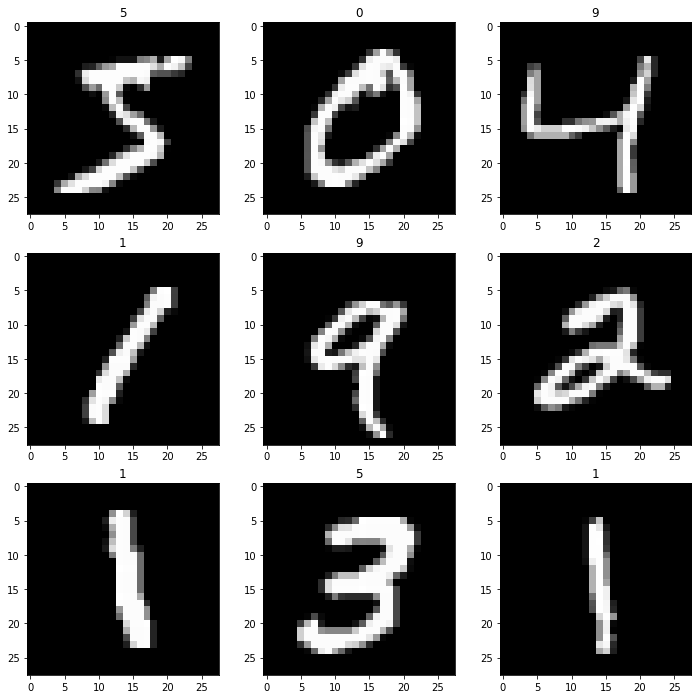

In [48]:
plot_images(train_ds_noisy)

In [49]:
tf.keras.backend.clear_session()
start_time = time.time()
tf.random.set_seed(123)
model = base_model(10)
loss_func = tf.keras.losses.CategoricalCrossentropy()
loss_func_2 = tf.keras.losses.CategoricalCrossentropy(reduction=tf.keras.losses.Reduction.NONE)
optimizer = tf.keras.optimizers.Adam(lr)
logs_nb_50_sym = train_test_model(
                                train_ds_noisy, 
                                test_ds, 
                                test_ds, 
                                loss_func, 
                                loss_func_2, 
                                num_epochs)
print(f"Training time : {(time.time() - start_time)/60:.2f} min.")

Epoch [1/50],	train loss: 2.3366,	train acc: 12.35 %,	validation loss: 2.2413,	validation accuracy: 38.43 %
Epoch [2/50],	train loss: 2.2241,	train acc: 18.40 %,	validation loss: 2.0897,	validation accuracy: 51.11 %
Epoch [3/50],	train loss: 2.1341,	train acc: 23.65 %,	validation loss: 1.9622,	validation accuracy: 61.48 %
Epoch [4/50],	train loss: 2.0485,	train acc: 28.80 %,	validation loss: 1.8322,	validation accuracy: 69.07 %
Epoch [5/50],	train loss: 1.9721,	train acc: 32.75 %,	validation loss: 1.7772,	validation accuracy: 71.92 %
Epoch [6/50],	train loss: 1.8987,	train acc: 36.55 %,	validation loss: 1.6809,	validation accuracy: 76.23 %
Epoch [7/50],	train loss: 1.8345,	train acc: 38.85 %,	validation loss: 1.6473,	validation accuracy: 77.43 %
Epoch [8/50],	train loss: 1.7656,	train acc: 40.90 %,	validation loss: 1.5809,	validation accuracy: 78.60 %
Epoch [9/50],	train loss: 1.6995,	train acc: 43.35 %,	validation loss: 1.5285,	validation accuracy: 79.54 %
Epoch [10/50],	train loss: 1

2. 70% symmetric noise

In [50]:
train_ds_noisy = (tf.data.Dataset.from_tensor_slices((x_train_base, label_noise['70_sym']))
                            .map(convert_to_one_hot, num_parallel_calls=tf.data.AUTOTUNE)
                            .batch(batch_size))

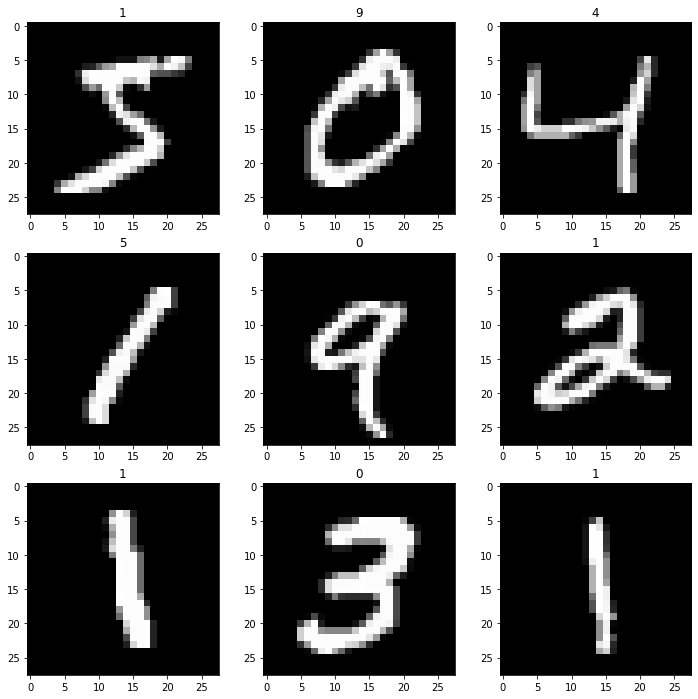

In [51]:
plot_images(train_ds_noisy)

In [52]:
tf.keras.backend.clear_session()
start_time = time.time()
tf.random.set_seed(123)
model = base_model(10)
loss_func = tf.keras.losses.CategoricalCrossentropy()
loss_func_2 = tf.keras.losses.CategoricalCrossentropy(reduction=tf.keras.losses.Reduction.NONE)
optimizer = tf.keras.optimizers.Adam(lr)
logs_nb_70_sym = train_test_model(
                                train_ds_noisy, 
                                test_ds, 
                                test_ds, 
                                loss_func, 
                                loss_func_2, 
                                num_epochs)
print(f"Training time : {(time.time() - start_time)/60:.2f} min.")

Epoch [1/50],	train loss: 2.3532,	train acc: 11.30 %,	validation loss: 2.2885,	validation accuracy: 10.53 %
Epoch [2/50],	train loss: 2.2898,	train acc: 12.25 %,	validation loss: 2.2765,	validation accuracy: 13.79 %
Epoch [3/50],	train loss: 2.2696,	train acc: 12.45 %,	validation loss: 2.2108,	validation accuracy: 26.36 %
Epoch [4/50],	train loss: 2.2379,	train acc: 15.90 %,	validation loss: 2.1689,	validation accuracy: 32.12 %
Epoch [5/50],	train loss: 2.1997,	train acc: 19.40 %,	validation loss: 2.1164,	validation accuracy: 42.55 %
Epoch [6/50],	train loss: 2.1627,	train acc: 21.30 %,	validation loss: 2.0909,	validation accuracy: 49.70 %
Epoch [7/50],	train loss: 2.1209,	train acc: 22.95 %,	validation loss: 2.0453,	validation accuracy: 55.46 %
Epoch [8/50],	train loss: 2.0782,	train acc: 24.65 %,	validation loss: 2.0268,	validation accuracy: 58.25 %
Epoch [9/50],	train loss: 2.0338,	train acc: 26.70 %,	validation loss: 1.9835,	validation accuracy: 57.36 %
Epoch [10/50],	train loss: 1

3. 40% asymmetric noise

In [53]:
train_ds_noisy = (tf.data.Dataset.from_tensor_slices((x_train_base, label_noise['40_asym']))
                            .map(convert_to_one_hot, num_parallel_calls=tf.data.AUTOTUNE)
                            .batch(batch_size))

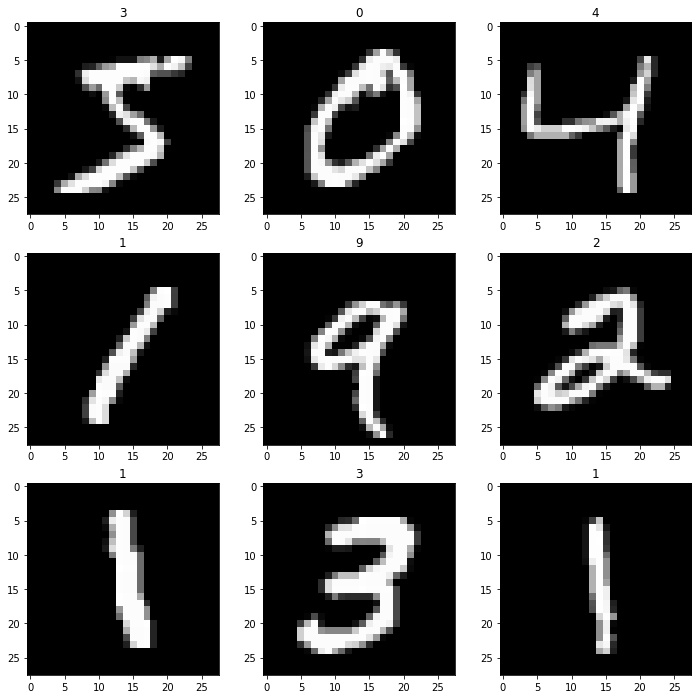

In [54]:
plot_images(train_ds_noisy)

In [55]:
tf.keras.backend.clear_session()
start_time = time.time()
tf.random.set_seed(123)
model = base_model(10)
loss_func = tf.keras.losses.CategoricalCrossentropy()
loss_func_2 = tf.keras.losses.CategoricalCrossentropy(reduction=tf.keras.losses.Reduction.NONE)
optimizer = tf.keras.optimizers.Adam(lr)
logs_nb_40_asym = train_test_model(
                                train_ds_noisy, 
                                test_ds, 
                                test_ds, 
                                loss_func, 
                                loss_func_2,
                                num_epochs)
print(f"Training time : {(time.time() - start_time)/60:.2f} min.")

Epoch [1/50],	train loss: 2.2548,	train acc: 16.95 %,	validation loss: 2.0932,	validation accuracy: 37.42 %
Epoch [2/50],	train loss: 1.9118,	train acc: 30.20 %,	validation loss: 1.7929,	validation accuracy: 52.38 %
Epoch [3/50],	train loss: 1.6544,	train acc: 41.75 %,	validation loss: 1.5483,	validation accuracy: 56.99 %
Epoch [4/50],	train loss: 1.4646,	train acc: 48.65 %,	validation loss: 1.4150,	validation accuracy: 59.95 %
Epoch [5/50],	train loss: 1.3354,	train acc: 52.30 %,	validation loss: 1.3017,	validation accuracy: 62.52 %
Epoch [6/50],	train loss: 1.2282,	train acc: 55.00 %,	validation loss: 1.2061,	validation accuracy: 63.87 %
Epoch [7/50],	train loss: 1.1294,	train acc: 58.45 %,	validation loss: 1.1101,	validation accuracy: 64.56 %
Epoch [8/50],	train loss: 1.0457,	train acc: 61.05 %,	validation loss: 1.0449,	validation accuracy: 64.04 %
Epoch [9/50],	train loss: 0.9807,	train acc: 63.40 %,	validation loss: 0.9864,	validation accuracy: 63.99 %
Epoch [10/50],	train loss: 0

### Plotting results

Text(0, 0.5, 'Loss')

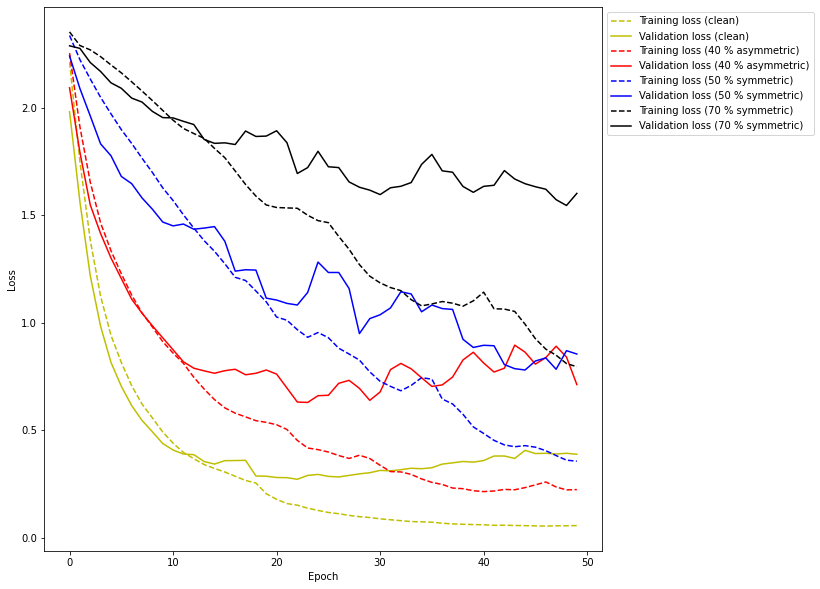

In [56]:
plt.figure(figsize=(10, 10))
logs = [logs_baseline, logs_nb_40_asym, logs_nb_50_sym, logs_nb_70_sym]
log_names = ['clean', '40 % asymmetric', '50 % symmetric', '70 % symmetric']
colors = 'yrbk'
for i in range(len(logs)):
    plt.plot(range(num_epochs), logs[i]['train_loss'], linestyle = '--', color = colors[i], label = 'Training loss ('+ log_names[i] + ')')
    plt.plot(range(num_epochs), logs[i]['val_loss'], color = colors[i], label = 'Validation loss ('+ log_names[i] + ')')
plt.legend(bbox_to_anchor=(1,1), loc="upper left")
plt.xlabel('Epoch')
plt.ylabel('Loss')

Text(0, 0.5, 'Accuracy')

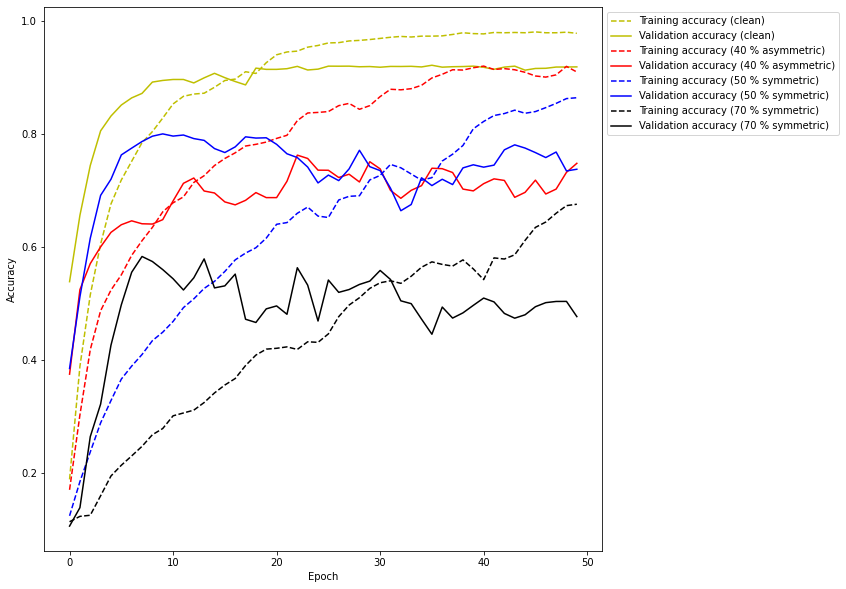

In [62]:
plt.figure(figsize=(10, 10))
for i in range(len(logs)):
    plt.plot(range(num_epochs), logs[i]['train_acc'], linestyle = '--', color = colors[i], label = 'Training accuracy ('+ log_names[i] + ')')
    plt.plot(range(num_epochs), logs[i]['val_acc'], color = colors[i], label = 'Validation accuracy ('+ log_names[i] + ')')
plt.legend(bbox_to_anchor=(1,1), loc="upper left")
plt.xlabel('Epoch')
plt.ylabel('Accuracy')

# Issues encountered

1. Accuracy metric does not reset itself when running a new model after a previous model has been run. Result is, accuracy is not being tracked throughout model.

**Workaround :**  Train each model only the first time and then reset kernel before training another model.

**Insight :** After the first model is trained, the graph seems to not get destroyed when `tf.keras.backend.clear_session()` is called. This is because when training the second model, the accuracy is being tracked inside the `@tf.function`s but not outside them, where there is eager execution.

**Solution :** Replaced accuracy metric with in place calculation of accuracy using basic tensor operations.

2. After the first model is trained, the second, third and fourth models seem to have loss curves that are almost flat.

**Insight :** The loss functions instantiated after the first model is run, do not get initialized afresh by `tf.keras.backend.clear_session()`, which means that the loss gets tracked from the graph from the first session itself.

**Solution :** Define the tf functions as individual classes, with the loss functions defined inside them.

3. The loss curves and accuracy do not match the ones from the original tutorial

**Insight :** The loss function instantiated repeatedly inside the `@tf.function` does not backpropagate losses effectively. 

**Partial Solution :** Declare loss function within class scope but during initialization.

4. The validation loss is much higher than training loss.

**Solution :** When calling the loss function in `val_step`, change order of y_batch, y_pred

# Combating Noisy Labels

### Robust loss

In [58]:
#Active Passive Loss (ICML 2020)
#paper code: https://github.com/HanxunH/Active-Passive-Losses

In [116]:
class NormalizedCrossEntropy(Loss):
    def __init__(self, num_classes=10, scale=1.0):
        super(NormalizedCrossEntropy, self).__init__()
        self.num_classes = num_classes
        self.scale = scale
    
    def call(self, y_true, y_pred):
        # Expect labels to be one-hot encoded
        nce = tf.math.reduce_sum(y_true*tf.math.log(y_pred), axis=0)/(tf.math.reduce_sum(tf.math.log(y_pred), axis=0))
        return self.scale*tf.math.reduce_mean(nce)

**Note :** Reduced MAE

Original: `torch.abs(pred - label_one_hot).sum(dim=1)`
       
$MAE = \sum_{k=1}^{K} |\bm{p}(k|\bm{x}) - \bm{q}(k|\bm{x})|$

$MAE = \sum_{k=1}^{K}\bm{p}(k|\bm{x}) - p(y|\bm{x}) + (1 - p(y|\bm{x}))$
       
$MAE = 2 - 2p(y|\bm{x})$
        

In [144]:
class MAE(Loss):
    def __init__(self, scale=1.0):
        super(MAE, self).__init__()
        self.scale = scale
    
    def call(self, y_true, y_pred):
        mae = 1.0-tf.math.reduce_sum(y_true*y_pred)
        return self.scale*mae

In [131]:
loss_1 = NormalizedCrossEntropy(10, 1)
loss_2 = MAE(1)
loss_3 = NCEandMAE(1, 1, 10)
y_true = tf.one_hot(y_train[12], 10)
y_pred = model(x_train[12].reshape(-1, 28, 28, 1))
print(loss_1(y_true, y_pred), loss_2(y_true, y_pred), loss_3(y_true, y_pred))

tf.Tensor(0.1, shape=(), dtype=float32) tf.Tensor(0.00052434206, shape=(), dtype=float32) tf.Tensor(0.10052434, shape=(), dtype=float32)


In [142]:
class NCEandMAE(Loss):
    def __init__(self, alpha, beta, num_classes=10):
        super(NCEandMAE, self).__init__()
        self.num_classes = num_classes
        self.nce = NormalizedCrossEntropy(scale=alpha, num_classes=num_classes)
        self.mae = MAE(scale=beta)
    
    def call(self, y_true, y_pred):
        print('NCE ', self.nce(y_true, y_pred))
        print('MAE ', self.mae(y_true, y_pred))
        return self.nce(y_true, y_pred) + self.mae(y_true, y_pred)

Training with Active Passive Loss

In [143]:
train_ds_noisy = (tf.data.Dataset.from_tensor_slices((x_train_base, label_noise['70_sym']))
                            .map(convert_to_one_hot, num_parallel_calls=tf.data.AUTOTUNE)
                            .batch(batch_size))

In [141]:
tf.keras.backend.clear_session()
start_time = time.time()
tf.random.set_seed(123)
model = base_model(10)
loss_func = NCEandMAE(alpha=1.0, beta=1.0, num_classes=10)
loss_func_2 = tf.keras.losses.CategoricalCrossentropy(reduction=tf.keras.losses.Reduction.NONE)
optimizer = tf.keras.optimizers.Adam(lr)
logs_nb_70_sym_APL = train_test_model(
                                train_ds_noisy, 
                                test_ds, 
                                test_ds, 
                                loss_func, 
                                loss_func_2, 
                                1)
print(f"Training time : {(time.time() - start_time)/60:.2f} min.")

AttributeError: in user code:

    File "C:\Users\debaj\AppData\Local\Temp\ipykernel_15332\3124824844.py", line 20, in __call__  *
        loss = self.loss_fn(y_batch, y_pred)
    File "C:\Users\debaj\AppData\Local\Temp\ipykernel_15332\3074475933.py", line 9, in call  *
        print('NCE ', self.nce(y_true, y_pred).numpy())

    AttributeError: 'Tensor' object has no attribute 'numpy'


ValueError: x and y must have same first dimension, but have shapes (50,) and (3,)

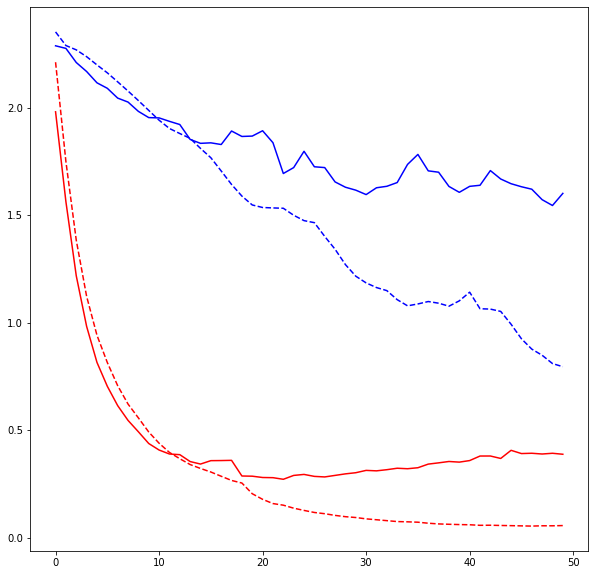

In [135]:
plt.figure(figsize=(10, 10))
logs = [logs_baseline, logs_nb_70_sym, logs_nb_70_sym_APL]
log_names = ['clean', '70 % symmetric', '70 % symmetric with APL']
colors = 'rbk'
for i in range(len(logs)):
    plt.plot(range(num_epochs), logs[i]['train_loss'], linestyle = '--', color = colors[i], label = 'Training loss ('+ log_names[i] + ')')
    plt.plot(range(num_epochs), logs[i]['val_loss'], color = colors[i], label = 'Validation loss ('+ log_names[i] + ')')
plt.legend(bbox_to_anchor=(1,1), loc="upper left")
plt.xlabel('Epoch')
plt.ylabel('Loss')

In [ ]:
plt.figure(figsize=(10, 10))
for i in range(len(logs)):
    plt.plot(range(num_epochs), logs[i]['train_acc'], linestyle = '--', color = colors[i], label = 'Training accuracy ('+ log_names[i] + ')')
    plt.plot(range(num_epochs), logs[i]['val_acc'], color = colors[i], label = 'Validation accuracy ('+ log_names[i] + ')')
plt.legend(bbox_to_anchor=(1,1), loc="upper left")
plt.xlabel('Epoch')
plt.ylabel('Accuracy')

In [71]:
# Issues encountered

1. `fit_gmm()` gives error saying `losses` has `NaN` values

**Workaround :**  abc

**Insight :** abc

**Solution :** abc

SyntaxError: invalid syntax (779512008.py, line 3)

# Issues encountered

1. `fit_gmm()` throws error saying that `losses` contains `NaN` values

**Workaround :**  

**Insight :** 

**Solution :** 

### Loss trick